In [6]:
#### Dependencies ####

import numpy as np
import logging
import sys
import time
import joblib
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM # Only necessary for feature extraction.

# Repository imports
from ridge_utils.ridge import bootstrap_ridge
import ridge_utils.npp
from ridge_utils.util import make_delayed
from ridge_utils.dsutils import make_word_ds
from ridge_utils.DataSequence import DataSequence
from ridge_utils.tokenization_helpers import generate_efficient_feat_dicts_opt
from ridge_utils.tokenization_helpers import convert_to_feature_mats_opt

### Some extra helper functions

zscore = lambda v: (v - v.mean(0)) / v.std(0)
zscore.__doc__ = """Z-scores (standardizes) each column of [v]."""
zs = zscore

## Matrix corr -- find correlation between each column of c1 and the corresponding column of c2
mcorr = lambda c1, c2: (zs(c1) * zs(c2)).mean(0)
mcorr.__doc__ = """Matrix correlation. Find the correlation between each column of [c1] and the corresponding column of [c2]."""

### Ignore irrelevant warnings that muck up the notebook
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Some parameters
NUM_VOX = 95556 # Number of voxels in the subject we plan to use
NUM_TRS = 790 # Number of TRs across 3 test stories
trim_start = 50 # Trim 50 TRs off the start of the story
trim_end = 5 # Trim 5 off the back
ndelays = 4 # We use 4 FIR delays (2 seconds, 4 seconds, 6 seconds, 8 seconds)
delays = range(1, ndelays + 1)

/n/home04/cfang/.conda/envs/sae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from configs import engram_dir, allstories
import os

box_dir = os.path.join(engram_dir, 'huth_box/')

# Load text data

In [7]:
box_dir = os.path.join(engram_dir, 'huth_box/')
grids = joblib.load(os.path.join(box_dir, "grids_huge.jbl")) # Load TextGrids containing story annotations
trfiles = joblib.load(os.path.join(box_dir, "trfiles_huge.jbl")) # Load TRFiles containing TR information

wordseqs = make_word_ds(grids, trfiles)
for story in wordseqs.keys():
    wordseqs[story].data = [i.strip() for i in wordseqs[story].data]
print("Loaded text data")
test_stories = ['wheretheressmoke']

Loaded text data


# Load LLM

In [9]:
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch

from transformer_lens.utils import tokenize_and_concatenate
from huggingface_hub import login
from transformer_lens.components import TransformerBlock
from configs import huggingface_token

login(token=huggingface_token)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HookedTransformer.from_pretrained("gemma-2-2b", device=device)
tokenizer = model.tokenizer
def override_to_local_attn(model, window_size=512):
    for b in model.blocks:  # Possibly a cleaner way by correctly using 'use_local_attn'
        if isinstance(b, TransformerBlock):
            n_ctx = b.attn.cfg.n_ctx
            attn_mask = torch.zeros((n_ctx, n_ctx)).bool()
            for i in range(n_ctx):
                start_idx = max(0, i-window_size)
                attn_mask[i, start_idx:i+1] = True
            b.attn.mask = attn_mask.to(device)

override_to_local_attn(model)
def find_word_boundaries(text_data, tokenizer):
    full_story = " ".join(text_data).strip()
    tokenized_story = tokenizer(full_story)['input_ids']

    word_boundaries = []  # In the tokenized story
    curr_word_idx = 0
    curr_word = text_data[curr_word_idx]
    curr_token_set = []

    if curr_word == '':
        curr_word_idx += 1
        curr_word = text_data[curr_word_idx]
        word_boundaries.append(1)

    for token_idx, token in enumerate(tokenized_story):
        curr_token_set.append(token)
        detokenized_chunk = tokenizer.decode(curr_token_set)
        if curr_word in detokenized_chunk:
            word_boundaries.append(token_idx)
            curr_word_idx += 1
            if curr_word_idx == len(text_data):
                break
            curr_word = text_data[curr_word_idx]
            curr_token_set = []

            if curr_word == '':  # Edge case
                word_boundaries.append(token_idx)
                curr_word_idx += 1
                if curr_word_idx == len(text_data):
                    break
                curr_word = text_data[curr_word_idx]

    return tokenized_story, word_boundaries

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Loaded pretrained model gemma-2-2b into HookedTransformer


In [10]:
llm_test_responses = []
for test_story in test_stories:
    ws = wordseqs[test_story]
    text_data = ws.data
    tokenized_story, word_boundaries = find_word_boundaries(text_data, tokenizer)
    with torch.no_grad():
        _, cache = model.run_with_cache(
            torch.tensor(tokenized_story).to(device),
            prepend_bos=True,
            names_filter=lambda name: name.startswith('blocks.7.hook_resid_post'),
        )
    llm_response = cache['blocks.7.hook_resid_post'][0, word_boundaries, :]
    llm_data_seq = DataSequence(llm_response.cpu().numpy(), ws.split_inds, ws.data_times, ws.tr_times)
    interp_llm_response = llm_data_seq.chunksums('lanczos', window=3)
    interp_llm_response = ridge_utils.npp.zs(interp_llm_response[10:-5])
    llm_test_responses.append(interp_llm_response[40:])

llm_test_responses = np.vstack(llm_test_responses)
print(llm_test_responses.shape)
del cache
torch.cuda.empty_cache()

(251, 2304)


In [13]:
X_test = make_delayed(llm_test_responses, delays)

# Load fMRI data

In [26]:
tensessions = joblib.load(os.path.join(box_dir, "stored_activations", "tensessions_wheretheressmoke_S03.jbl"))

# Get Model predictions

In [16]:
np.random.seed(0)
selected_features = np.random.choice(tensessions.shape[-1], size=5000, replace=False)
np.random.seed()

In [17]:
import pickle
with open('gemma_regression_weights.pkl', 'rb') as f:
    wt = pickle.load(f)


In [24]:
# Dot the weights with the features to get voxelwise model predictions
pred = (wt @ X_test.T).T

# Compare to fMRI data

In [29]:
_pred = pred
_tensessions = tensessions[:, 40:, selected_features]


In [30]:
def spe_and_cc_norm(orig_data, data_pred, data_norm=True, max_flooring=None):
    '''
    Computes the signal power explained and the cc_norm of a model given the observed and predicted values
    Assumes normalization unless data_norm is set to False
    
    orig_data: 3D numpy array (trials, timepoints, voxels)
    
    data_pred: 2D numpy array (timepoints, voxels)
    
    data_norm: bool -> Set to False if not pre-normalized
    
    max_flooring: None/float (0-1) -> If not None, compute cc_norm in an alternate way that floors cc_max by max_flooring.
    This is helpful to clean up bad voxels that are not at all language selective.
    
    According to Schoppe: https://www.frontiersin.org/articles/10.3389/fncom.2016.00010/full
    '''
    y = np.mean(orig_data, axis=0)
    num_trials = len(orig_data)
    if not data_norm:
        variance_across_time = np.var(orig_data, axis=1, ddof=1)
        TP = np.mean(variance_across_time, axis=0)
    else:
        TP = np.zeros(orig_data.shape[2]) + 1
    SP = (1 / (num_trials-1)) * ((num_trials * np.var(y, axis=0, ddof=1)) - TP) 
    SPE_num = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1)) 
    SPE = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1)) / SP
    y_flip = np.swapaxes(y, axis1=0, axis2=1)
    data_flip = np.swapaxes(data_pred, axis1=0, axis2=1)
    covs = np.zeros(y_flip.shape[0])
    for i, row in enumerate(y_flip):
        covs[i] = np.cov(y_flip[i], data_flip[i])[0][1]
    cc_norm =  np.sqrt(1/SP) * (covs / np.sqrt(np.var(data_pred, axis=0, ddof=1)))
    cc_max = None
    if max_flooring is not None:
        cc_max = np.nan_to_num(1 / (np.sqrt(1 + ((1/num_trials) * ((TP/SP)-1)))))
        #cc_max = np.maximum(cc_max, np.zeros(cc_max.shape) + max_flooring)
        corrs = np.zeros(y_flip.shape[0])
        for i, row in enumerate(y_flip):
            corrs[i] = np.corrcoef(y_flip[i], data_flip[i])[0][1]
        cc_norm = corrs / cc_max
    return SPE, cc_norm, cc_max, corrs


In [31]:

SPE, cc_norm, cc_max, corrs_unnorm = spe_and_cc_norm(_tensessions, _pred, max_flooring=0.25)



In [32]:
print(cc_norm)
print(cc_max)
print(corrs_unnorm)


[0.46675302 0.32831316 0.45939534 ... 0.5262881  0.69162531 0.79441926]
[0.78707599 0.44049137 0.48035841 ... 0.66926356 0.54646858 0.20779704]
[0.3673701  0.14461911 0.22067442 ... 0.35222545 0.3779515  0.16507797]


In [35]:
cc_norm = np.array(cc_norm)

In [36]:
print((cc_norm == np.inf).sum())
print((cc_norm == -np.inf).sum())

615
32


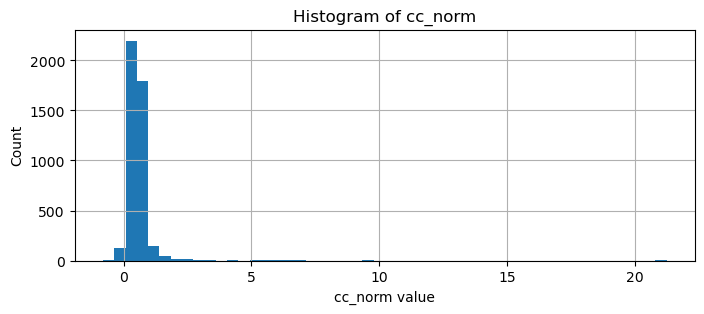

Mean cc_norm: 0.535
Median cc_norm: 0.491
Std cc_norm: 0.522


In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
cc_norm_finite = cc_norm[~np.isinf(cc_norm)]
plt.hist(cc_norm_finite, bins=50)
plt.title('Histogram of cc_norm')
plt.xlabel('cc_norm value')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(f"Mean cc_norm: {np.mean(cc_norm_finite):.3f}")
print(f"Median cc_norm: {np.median(cc_norm_finite):.3f}") 
print(f"Std cc_norm: {np.std(cc_norm_finite):.3f}")